In [1]:
import os
import glob
import numpy as np
import pandas as pd
import math
from numpy import exp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# from pandas_datareader import data as pdr
# import fix_yahoo_finance as yf
from collections import deque
import random
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


Using TensorFlow backend.


# Load the dataset for training the model

In [ ]:
path = "./train_data_2008-2011"


portfolio = []
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        portfolio.append(filename.split(".csv")[0])
print(len(portfolio))
portfolio

# Class agent

In [3]:


class Agent:
    def __init__(self, state_size, window_size, stock_name, trend, batch_size, existed_model=False):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.stock_name = stock_name
        self.trend = trend
        self.action_size = 3 #buy hold sell
        self.batch_size = batch_size
        self.memory = deque(maxlen = 2000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        if(existed_model == True):
            self.model = load_model("./model_2008-2011/model_%s" % (self.stock_name))
        else:
            self.model = self._model()
            
    def _model(self):
        model = Sequential()
        model.add(Dense(units=128, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=64, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", metrics=['mean_squared_error'], optimizer=Adam(lr=0.001))
        return model
    
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        action = self.model.predict(state)[0]
        return np.argmax(action)

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        
        # Q-value of current state
        Q = self.model.predict(states)
        # Q-value of next state
        Q_new = self.model.predict(new_states)
        
        for i in range(len(mini_batch)):
            
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                # Bellman equation
                target[action] += reward + self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        
        # fit the model
        self.model.fit(X, Y, epochs=1, verbose=0, batch_size=64)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def buy(self, initial_money):
        
#         print(self.memory)
        cash_in_hand = initial_money
        total_money = []
        share_hold_in_hand = 0
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        
        for t in range(0, len(self.trend) - 1):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            # buy
            if action == 1 and cash_in_hand >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                cash_in_hand -= self.trend[t]
                share_hold_in_hand += 1
                states_buy.append(t)
#                 print('Day %d: buy 1 unit at price %f, cash in hand %f'% (t, self.trend[t], cash_in_hand))

            # sell
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                cash_in_hand += self.trend[t]
                share_hold_in_hand -= 1
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
#                 print(
#                     'Day %d, sell 1 unit at price %f, investment %f %%, cash in hand %f,'
#                     % (t, self.trend[t], invest, cash_in_hand)
#                 )

            state = next_state
            total_money.append(cash_in_hand + share_hold_in_hand*self.trend[t])
        print("close[-1]:",self.trend[-1])
        invest = ((total_money[-1] - initial_money) / initial_money) * 100
        total_gains = total_money[-1] - initial_money
        return states_buy, states_sell, total_money, total_gains, invest
    
    def train(self, iterations, checkpoint, initial_money):
        total_money = 0
        for i in range(iterations):
            total_profit = 0
            shares_hold_in_hand = 0
            inventory = []
            state = self.get_state(0)
            cash_in_hand = initial_money

            for t in range(200, len(self.trend) - 1):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                # hold
                reward = self.trend[t-1]/self.trend[t-200]
                # buy
                if action == 1 and cash_in_hand >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    cash_in_hand -= self.trend[t]
                    shares_hold_in_hand += 1
                    reward = (1 + 1 * (self.trend[t]-self.trend[t-1])/self.trend[t-1])*(self.trend[t-1]/self.trend[t-200])
                # sell
                elif action == 2 and len(inventory)>0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    cash_in_hand += self.trend[t]
                    shares_hold_in_hand -= 1
                    reward = (1 + -1 * (self.trend[t]-self.trend[t-1])/self.trend[t-1])*(self.trend[t-1]/self.trend[t-200])
                    
                # calculate current total asset
                total_money = cash_in_hand + (len(inventory)*self.trend[t])

                done = True if t == len(self.trend) - 1 else False
                self.memory.append((state, action, reward, 
                                    next_state, done))

                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print("inventory: ",inventory)
                print('epoch: %d, total rewards: %f.3, cash in hand: %f, total money: %f'%(i + 1, total_profit,cash_in_hand,total_money))

        self.model.save("./model_2008-2011/model_%s" % (self.stock_name))
        
        
                                                                                   

# Train the data

2018.瑞聲科技
10.3
inventory:  [17.92, 16.52, 16.4, 17.58, 17.66]
epoch: 10, total rewards: 239.329995.3, cash in hand: 10153.249995, total money: 10240.649995
inventory:  []
epoch: 20, total rewards: 162.519994.3, cash in hand: 10162.519994, total money: 10162.519994
inventory:  []
epoch: 30, total rewards: 31.239999.3, cash in hand: 10031.239999, total money: 10031.239999
inventory:  []
epoch: 40, total rewards: 111.300008.3, cash in hand: 10111.300008, total money: 10111.300008
inventory:  [20.799999, 20.15, 20.049999, 19.82, 19.5, 19.459999, 19.68, 19.42, 18.76, 18.200001, 19.58, 19.9, 20.1, 19.84, 19.639999, 20.049999, 20.4, 20.1, 20.049999, 19.0, 19.379999, 18.48, 18.459999, 18.52, 19.0, 18.52, 18.4, 18.24, 18.280001, 18.559999, 19.700001, 21.0, 21.950001, 21.549999, 21.049999, 21.450001, 21.049999, 20.75, 20.35, 20.15, 20.0, 19.98, 19.34, 20.9, 21.700001, 20.9, 20.25, 20.1, 20.299999, 20.4, 20.950001, 20.549999, 21.1, 20.75, 19.879999, 19.799999, 19.639999, 19.459999, 19.540001, 18.

inventory:  [3.16, 2.94, 2.69, 2.5, 2.47, 2.52, 2.33, 2.4, 2.42, 2.43, 2.5, 2.57, 2.66, 2.65, 2.74, 2.95, 2.9, 2.93, 2.89, 2.85, 3.13, 3.16, 3.17, 3.0, 3.0, 3.02, 3.15, 3.13, 3.32, 3.2, 3.3, 3.42, 3.4, 3.6, 3.61, 3.5, 3.7, 3.8, 3.65, 3.65, 3.71, 4.0, 4.28, 4.4, 4.45, 4.27, 4.08, 4.22, 4.26, 4.0, 4.17, 4.12, 4.12, 4.12, 4.29, 4.36, 4.01, 4.0, 4.1, 4.22, 4.27, 4.31, 4.41, 4.7, 5.13, 5.0, 4.97, 4.9, 5.14, 5.69, 5.6, 5.97, 6.23, 6.5, 6.18, 6.07, 5.72, 6.16, 6.38, 6.41, 6.46, 6.72, 6.25, 6.54, 6.18, 5.93, 5.84, 5.66, 5.72, 5.33, 5.5, 5.59, 5.59, 5.5, 5.61, 5.5, 5.84, 6.2, 6.3, 6.16, 6.17, 6.22, 6.19, 6.1, 6.12, 5.81, 5.99, 6.03, 5.9, 5.81, 5.98, 6.18, 6.04, 5.88, 5.95, 6.4, 6.7, 6.98, 7.49, 7.6, 6.82, 7.26, 7.48, 7.44, 7.35, 7.0, 7.0, 6.95, 7.0, 6.93, 6.93, 6.77, 6.95, 6.7, 6.56, 6.73, 6.71, 6.72, 6.92, 6.97, 6.9, 6.61, 6.41, 6.42, 6.45, 6.4, 6.41, 6.52, 6.91, 7.28, 7.19, 7.37, 7.47, 8.48, 8.68, 8.31, 8.4, 8.36, 8.24, 8.16, 8.67, 8.6, 8.9, 8.68, 8.88, 8.47, 8.21, 8.36, 8.35, 8.8, 8.89, 8.8,

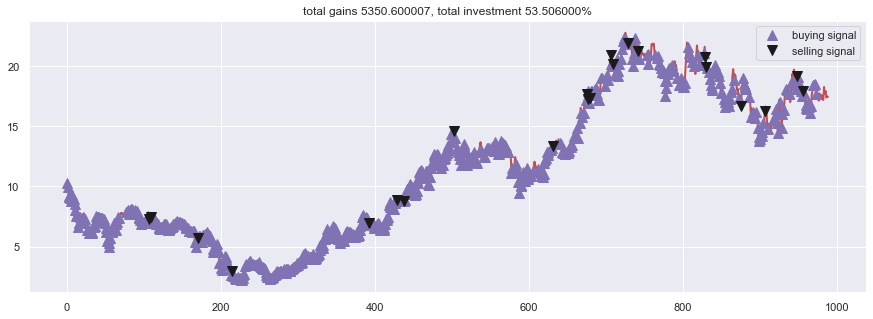

2688.新奧能源
14.96
inventory:  [23.75, 23.75, 23.6, 22.85, 22.799999, 22.799999, 23.700001, 23.549999, 23.549999, 24.9, 24.9, 24.549999, 23.4, 24.950001, 24.85, 24.25, 24.9, 24.0, 24.85, 24.5, 24.25, 23.4, 23.5, 22.85, 23.299999, 23.549999, 24.700001, 25.0, 25.15, 25.15, 24.549999, 25.1, 24.799999, 22.9, 23.85, 24.450001, 24.65, 24.15, 23.9, 23.85, 23.75, 24.25, 24.299999, 24.65, 24.4, 24.6, 24.1, 24.65, 24.299999, 24.75, 25.0, 25.549999, 25.65, 26.15, 24.799999, 24.200001, 24.4, 24.200001, 24.299999, 24.049999, 24.85, 24.700001, 24.700001, 25.4, 27.0, 26.9, 27.0, 26.75, 26.5, 27.200001, 27.700001, 27.549999, 27.0, 26.549999, 26.6, 26.700001, 26.950001, 26.9, 26.950001, 28.549999, 27.450001, 27.0, 27.049999, 26.65, 26.700001, 27.85, 26.65, 25.85, 26.4, 26.6, 26.9, 27.65, 28.0, 27.950001, 27.65, 27.0, 27.35, 29.450001, 25.25, 26.299999, 25.1, 25.549999, 25.9, 25.9, 28.049999, 28.549999, 27.799999, 27.299999, 25.200001, 24.549999, 26.200001, 26.5, 27.049999, 27.25, 27.35, 27.35, 27.5, 27.5,

inventory:  [24.35, 23.4, 23.5, 23.5, 22.85, 23.299999, 25.0, 25.15, 25.65, 25.299999, 25.35, 25.35, 25.450001, 24.9, 24.950001, 25.6, 23.700001, 23.1, 23.85, 24.15, 24.200001, 24.299999, 24.25, 23.9, 23.75, 23.15, 24.15, 24.450001, 24.25, 24.299999, 24.65, 24.4, 24.6, 24.299999, 25.0, 25.65, 24.799999, 24.200001, 24.200001, 24.299999, 24.049999, 24.700001, 26.9, 26.75, 27.0, 26.549999, 26.6, 26.700001, 26.950001, 26.950001, 27.1, 27.450001, 28.450001, 28.700001, 27.35, 28.549999, 27.450001, 27.0, 27.049999, 27.0, 27.049999, 26.700001, 26.5, 27.049999, 27.85, 26.200001, 25.85, 25.049999, 26.200001, 26.4, 26.9, 27.75, 27.200001, 27.950001, 26.85, 27.200001, 26.25, 27.9, 25.549999, 24.5, 26.75, 28.549999, 27.299999, 28.6, 26.049999, 23.6, 23.299999, 24.549999, 27.5, 27.049999, 25.5]
epoch: 90, total rewards: 140.550008.3, cash in hand: 7804.450008, total money: 10070.350008
inventory:  [8.7, 8.43, 8.4, 9.17, 10.1, 10.0, 9.53, 10.18, 10.1, 10.12, 10.62, 11.0, 10.52, 10.54, 10.42, 11.0, 10

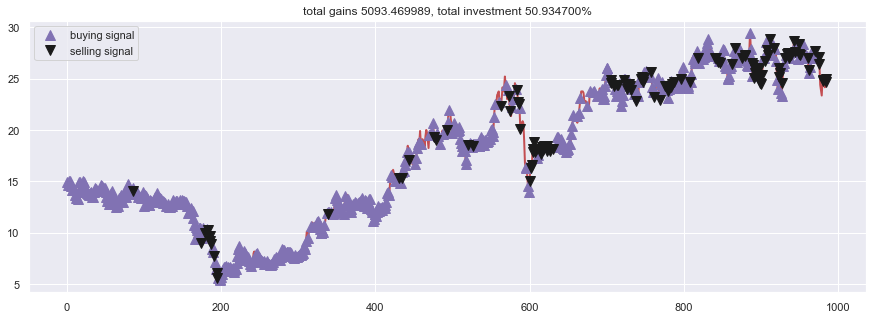

1038.長江基建集團
29.15
inventory:  [29.200001, 29.1, 29.4, 29.15, 29.15, 28.85, 28.200001, 28.4, 28.35, 28.25, 28.450001, 28.549999, 28.700001, 28.450001, 28.950001, 29.049999, 29.0, 29.0, 28.35, 28.1, 27.950001, 28.1, 28.0, 28.25, 27.9, 27.85, 27.700001, 27.700001, 27.65, 27.549999, 27.700001, 27.700001, 27.4, 27.450001, 27.299999, 27.700001, 28.450001, 28.25, 28.200001, 28.950001, 28.450001, 28.299999, 28.450001, 28.65, 28.5, 28.700001, 28.450001, 28.65, 28.700001, 28.85, 29.200001, 29.200001, 29.15, 28.9, 29.549999, 29.75, 29.950001, 29.950001, 30.0, 29.950001, 30.049999, 30.0, 30.200001, 30.200001, 30.1, 29.950001, 29.950001, 29.9, 29.950001, 30.549999, 30.200001, 30.4, 30.5, 30.6, 30.35, 30.4, 30.799999, 31.299999, 31.200001, 31.450001, 31.35, 31.75, 31.799999, 30.9, 31.4, 30.799999, 30.65, 31.5, 31.35, 31.9, 31.6, 32.049999, 32.0, 33.099998, 32.799999, 33.900002, 33.549999, 33.450001, 33.700001, 33.299999, 32.25, 32.400002, 33.0, 33.299999, 33.75, 32.950001, 34.0, 34.099998, 34.849998

inventory:  [30.200001, 30.1, 29.950001, 29.950001, 29.9, 30.549999, 30.5, 31.299999, 33.099998, 33.700001, 32.849998, 32.400002, 33.299999, 33.799999, 34.0, 34.200001, 34.200001, 33.099998, 33.849998, 34.75, 36.599998, 37.650002, 35.900002, 36.099998, 35.349998, 34.849998, 34.549999, 34.950001, 35.849998, 35.349998, 35.25, 34.900002, 35.700001, 35.799999, 35.599998, 36.0, 36.299999, 36.099998, 37.349998, 36.549999, 36.0, 35.849998, 36.200001, 36.150002, 36.650002, 36.400002, 36.349998, 36.900002, 36.799999, 36.799999, 37.200001, 36.599998, 36.299999, 37.349998, 37.700001, 37.049999, 36.799999, 37.349998, 37.950001, 38.099998, 38.5, 38.549999, 37.200001, 36.75, 36.75, 36.700001, 36.75, 37.25, 37.950001, 37.549999, 37.5, 37.599998, 37.950001, 38.400002, 38.450001, 37.5, 36.349998, 36.599998, 36.650002, 37.650002, 37.5, 37.349998, 37.25, 36.700001, 36.700001, 36.099998, 35.349998, 35.849998, 35.950001, 36.75, 36.75, 36.700001, 36.099998, 36.299999, 36.599998, 36.75, 36.5, 36.450001, 36.8

inventory:  [28.700001, 28.450001, 28.4, 28.700001, 28.85, 29.200001, 29.200001, 29.15, 28.9, 29.1, 29.549999, 29.700001, 29.9, 29.85, 29.75, 29.450001, 29.950001, 29.950001, 30.0, 29.950001, 30.049999, 30.0, 30.25, 30.200001, 30.200001, 30.1, 30.049999, 29.950001, 29.85, 29.950001, 29.9, 29.950001, 30.549999, 30.200001, 30.4, 30.5, 30.6, 30.35, 30.450001, 30.4, 30.200001, 30.799999, 31.299999, 31.200001, 30.9, 31.0, 30.799999, 30.65, 31.5, 31.35, 31.9, 31.6, 32.049999, 32.0, 32.150002, 33.099998, 33.049999, 32.799999, 32.900002, 33.900002, 33.549999, 33.450001, 33.700001, 33.299999, 32.849998, 32.25, 33.299999, 33.799999, 33.0, 34.099998, 34.849998, 34.299999, 33.950001, 34.0, 33.400002, 34.200001, 34.0, 33.099998, 33.849998, 34.150002, 34.75, 34.849998, 36.599998, 37.650002, 36.150002, 35.900002, 35.900002, 36.150002, 36.099998, 35.349998, 34.849998, 35.299999, 34.549999, 34.950001, 35.849998, 35.349998, 35.25, 34.900002, 35.700001, 35.799999, 35.599998, 36.0, 36.299999, 36.099998, 3

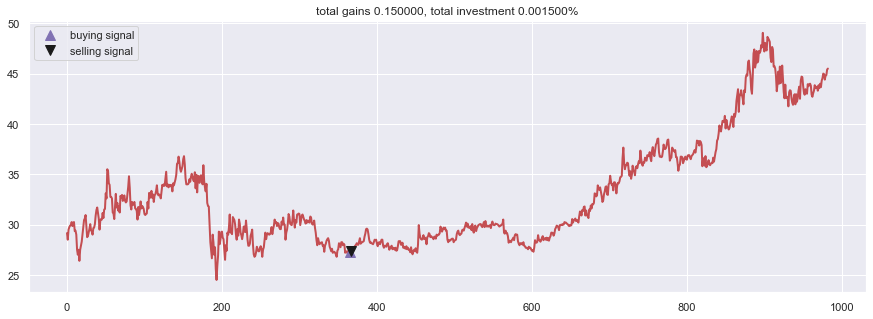

0939.建設銀行
6.315238
inventory:  []
epoch: 10, total rewards: 1.045041.3, cash in hand: 10001.045041, total money: 10001.045041
inventory:  [4.84, 4.83, 5.24, 5.01, 5.07, 5.12, 5.59, 5.4, 5.29, 5.2, 5.21, 5.18, 5.3, 5.26]
epoch: 20, total rewards: -8.559346.3, cash in hand: 9918.900654, total money: 9994.780654
inventory:  [6.45, 6.56, 6.48, 6.27, 5.82, 5.26, 5.35, 5.54, 5.53, 5.48, 5.55, 5.57, 5.68, 5.42, 5.13, 4.83, 5.24, 5.01, 5.85, 5.83, 5.65, 5.62, 5.71, 5.47, 5.59, 5.54, 5.4, 5.29, 5.21, 5.27, 5.26, 5.65, 5.65, 5.71]
epoch: 30, total rewards: 68.468035.3, cash in hand: 9878.598035, total money: 10062.878035
inventory:  []
epoch: 40, total rewards: 3.318914.3, cash in hand: 10003.318914, total money: 10003.318914
inventory:  [5.451864, 5.432462, 5.442163, 5.548872, 5.548872, 5.684684, 5.888401, 5.839897, 5.704085, 5.907803, 5.927204, 5.985409, 6.072717, 5.985409, 6.004811, 6.063016, 6.072717, 5.975709, 5.781692, 5.76229, 5.577975, 5.801094, 5.859299, 5.76229, 5.907803, 5.927204, 5.7

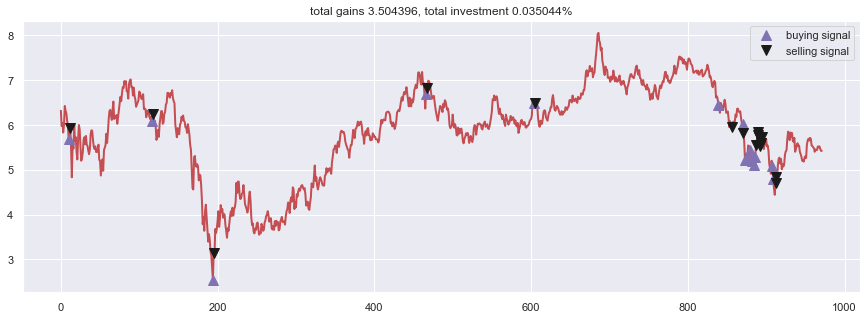

1137.香港科技探索
2.12
inventory:  [3.7, 4.17, 4.1]
epoch: 10, total rewards: -10.730000.3, cash in hand: 9977.300000, total money: 9989.360000
inventory:  [3.54, 3.56, 3.62, 3.62, 3.56, 3.57, 4.1, 4.09]
epoch: 20, total rewards: 4.990000.3, cash in hand: 9975.330000, total money: 10007.490000
inventory:  [0.89, 0.89, 0.89, 4.46, 4.96, 4.95, 4.92, 4.9, 4.81, 4.86, 4.8, 4.89, 4.87, 4.91, 4.96, 5.56, 5.68, 5.88, 5.64, 5.6, 5.57, 3.75, 3.84, 3.82, 3.8, 3.7, 3.75, 3.85, 3.8, 4.34, 4.17, 4.3, 4.26, 4.29, 4.26, 4.1, 4.1, 4.1, 4.09, 4.3, 4.15, 4.18, 4.17, 4.34]
epoch: 30, total rewards: -1.400000.3, cash in hand: 9810.250000, total money: 9987.130000
inventory:  []
epoch: 40, total rewards: -1.080000.3, cash in hand: 9998.920000, total money: 9998.920000
inventory:  []
epoch: 50, total rewards: 37.600000.3, cash in hand: 10037.600000, total money: 10037.600000
inventory:  []
epoch: 60, total rewards: -5.490000.3, cash in hand: 9994.510000, total money: 9994.510000
inventory:  [1.14, 1.2, 1.31, 1.32

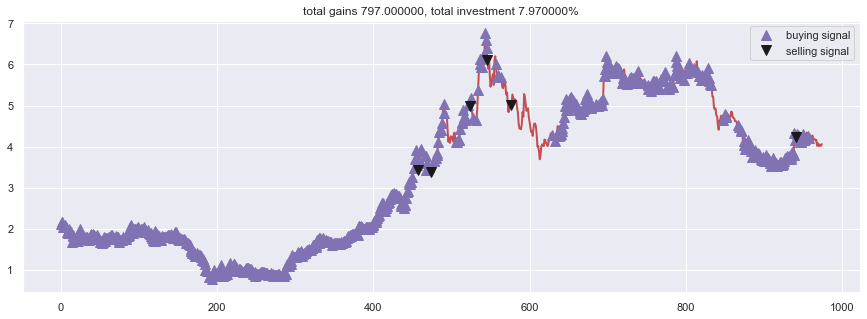

0981.中芯國際
7.9
inventory:  [6.4, 6.4, 6.5, 6.6, 6.5, 6.5, 6.5, 6.5, 6.3, 6.3, 6.0, 6.0, 6.3, 6.3, 6.3, 4.85, 4.7, 5.1, 4.95, 4.85, 4.7, 4.7, 4.65, 4.75, 4.65, 4.5, 4.6, 4.3, 3.75, 3.85, 4.15, 4.1, 4.0, 4.0, 4.1, 4.2, 4.4, 4.45, 4.55, 4.3, 4.05, 3.9, 3.75, 3.95, 4.0, 3.9, 3.85, 3.95, 4.2, 4.5, 4.2, 4.3, 4.25, 4.25, 4.45, 4.45, 4.4, 4.4, 4.1, 4.15, 4.05, 3.95, 3.8, 3.9, 3.85, 3.95, 3.95]
epoch: 10, total rewards: -91.560000.3, cash in hand: 9591.440000, total money: 9839.340000
inventory:  []
epoch: 20, total rewards: 2.420000.3, cash in hand: 10002.420000, total money: 10002.420000
inventory:  [3.0, 3.0, 2.95, 2.6, 2.47, 2.44, 2.5, 2.75, 2.65, 2.7, 2.7, 2.8, 2.5, 2.39, 2.45, 2.5, 2.48, 2.55, 2.5, 2.7, 2.9, 2.95, 2.75, 2.8, 2.7, 2.85, 2.7, 2.7, 2.55, 2.6, 2.65, 2.65, 2.6, 2.5, 2.5, 2.5, 2.6, 2.6, 2.65, 2.65, 2.8, 2.8, 2.65, 2.8, 2.9, 2.8, 2.85, 3.1, 3.0, 2.95, 2.9, 2.95, 3.1, 3.05, 3.0, 3.0, 2.95, 3.1, 3.4, 3.3, 3.35, 3.15, 3.1, 3.0, 3.05, 3.1, 2.9, 2.65, 2.85, 3.05, 3.2, 3.2, 3.3, 3.25, 

close[-1]: 3.75


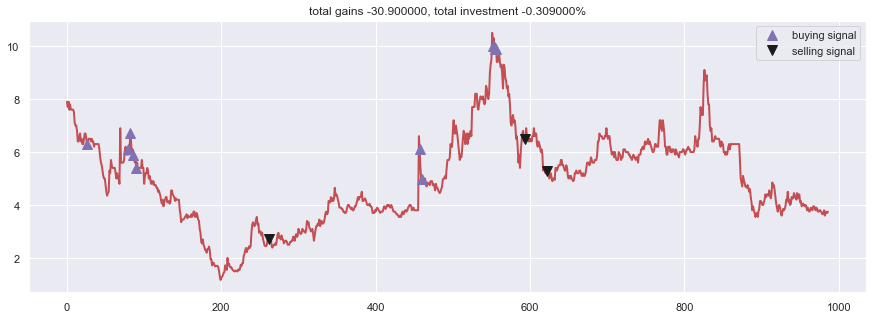

1385.上海復旦
1.08
inventory:  [2.75, 2.78, 2.85, 2.94, 3.02, 3.14, 3.05, 3.05, 3.06, 3.08, 3.05, 3.06, 3.07, 3.06, 3.14, 3.1, 3.08, 3.15, 3.2, 3.3, 3.18, 3.15]
epoch: 10, total rewards: 50.825000.3, cash in hand: 9983.565000, total money: 10053.965000
inventory:  [0.98, 0.98, 1.07, 1.05, 1.05, 1.17, 1.15, 1.12, 1.2, 1.43, 1.55, 1.53, 1.53, 1.6, 1.57, 1.67, 1.62, 1.64, 1.76, 1.96, 1.99, 2.03, 2.06, 1.97, 1.94, 1.84, 1.85, 1.82, 1.63, 1.52, 1.56, 1.52, 1.52, 1.68, 1.6, 1.62, 1.6, 1.6, 1.74, 1.78, 1.87, 1.82, 1.85, 1.82, 1.82, 1.79, 1.8, 1.81, 1.75, 1.84, 1.9, 1.9, 1.88, 1.8, 1.68, 1.61, 1.76, 1.93, 1.85, 1.72, 1.82, 1.77, 1.67, 1.67, 1.68, 1.7, 1.7, 1.7, 1.76, 1.76, 1.63, 1.75, 1.73, 1.69, 1.69, 1.73, 1.73, 1.75, 1.76, 1.7, 1.71, 1.73, 1.7, 1.72, 1.9, 1.93, 2.0, 2.02, 2.16, 2.3, 2.18, 2.34, 2.25, 2.3, 2.25, 2.27, 2.37, 2.32, 2.32, 2.41, 2.66, 2.8, 2.79, 2.9, 2.89, 2.94, 2.93, 2.85, 2.76, 2.69, 2.75, 2.81, 2.87, 2.98, 3.02, 2.9, 2.88, 3.0, 2.97, 2.94, 2.82, 2.73, 2.61, 2.59, 2.55, 2.62, 2.7,

inventory:  [2.76, 2.69, 2.75, 2.81, 2.87, 2.98, 3.02, 2.9, 2.88, 3.0, 2.97, 2.94, 2.82, 2.73, 2.61, 2.59, 2.55, 2.62, 2.7, 2.6, 2.57, 2.61, 2.53, 2.36, 2.56, 2.49, 2.6, 2.63, 2.76, 2.89, 2.85, 2.83, 2.91, 2.85, 2.76, 2.81, 2.72, 2.78, 2.77, 2.72, 2.8, 2.82, 2.8, 2.82, 2.83, 2.79, 2.87, 2.87, 2.88, 2.73, 2.93, 2.8, 2.76, 2.76, 2.78, 2.81, 2.88, 2.8, 2.84, 2.85, 2.9, 2.9, 2.91, 2.94, 2.9, 2.9, 2.85, 2.84, 2.89, 2.82, 2.92, 2.97, 3.26, 3.35, 3.45, 3.68, 3.6, 3.7, 3.56, 3.49, 3.49, 3.47, 3.4, 3.32, 3.23, 3.23, 3.4, 3.45, 3.38, 3.28, 3.2, 3.1, 3.17, 3.0, 3.02, 2.96, 3.0, 3.04, 2.93, 2.83, 2.7, 2.82, 3.07, 2.93, 2.92, 2.9, 2.9, 2.91, 2.85, 2.84, 2.87, 2.91, 2.98, 2.99, 2.83, 2.83, 2.84, 2.77, 2.8, 2.94, 2.88, 2.85, 2.89, 2.82, 2.81, 2.81, 2.82, 2.87, 2.86, 3.23, 3.18, 3.2, 3.32, 3.28, 3.38, 3.4, 3.54, 3.6, 3.64, 4.0, 3.85, 4.03, 4.22, 4.55, 4.41, 4.4, 4.28, 4.2, 4.04, 4.3, 4.3, 4.33, 4.24, 4.1, 4.05, 3.8, 4.0, 4.15, 4.21, 4.2, 4.29, 4.23, 4.2, 4.29, 4.05, 4.11, 3.83, 4.27, 4.18, 4.2, 4.14, 

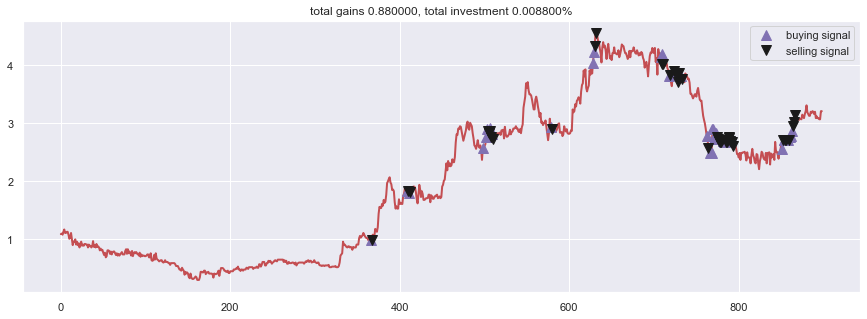

1109.華潤置地
16.299999
inventory:  [16.98, 16.26, 16.059999, 16.200001, 15.92, 15.84, 16.5, 16.24, 16.68, 17.24, 17.5, 17.84, 17.18, 17.16, 17.48, 17.74, 17.0, 16.76, 15.84, 15.9, 15.28, 16.24, 16.42, 16.440001, 16.559999, 16.299999, 16.6, 15.9, 16.799999, 17.6, 19.0, 19.52, 18.799999, 18.200001, 18.940001, 19.32, 18.299999, 18.24, 18.4, 17.379999, 17.200001, 17.440001, 16.76, 17.24, 17.459999, 16.700001, 17.040001, 17.1, 16.940001, 17.219999, 17.860001, 18.02, 17.4, 16.68, 16.6, 16.219999, 16.6, 15.9, 17.200001, 17.48, 17.84, 17.68, 17.959999, 18.200001, 17.559999, 18.1, 17.5, 17.16, 18.02, 17.26, 17.459999, 17.76, 17.42, 16.940001, 17.040001, 16.620001, 17.120001, 16.98, 17.219999, 16.84, 17.74, 18.24, 18.0, 17.9, 17.559999, 17.639999, 17.440001, 17.5, 17.9, 18.639999, 19.219999, 20.0, 20.1, 19.719999, 19.200001, 18.799999, 18.219999, 19.120001, 18.559999, 18.18, 18.52, 18.02, 18.16, 18.92, 19.02, 18.9, 18.48, 18.959999, 18.700001, 18.639999, 17.92, 17.58, 17.540001, 17.82, 17.9, 17.959

inventory:  [9.31, 10.24, 10.36, 10.34, 11.76, 12.2, 11.54, 11.2, 11.64, 11.82, 12.52, 12.22, 11.78, 12.18, 11.44, 11.76]
epoch: 50, total rewards: -243.050010.3, cash in hand: 9574.639990, total money: 9772.719990
inventory:  [9.58, 10.72, 10.04, 10.82, 10.14, 10.14, 9.46, 9.31, 10.24, 10.36, 10.34, 11.76, 12.2, 11.54, 11.2, 11.64, 11.82, 12.52, 12.22, 11.78, 12.18, 11.44, 11.3, 11.76, 11.72, 11.62, 11.14, 10.7, 10.22, 10.26, 12.56]
epoch: 60, total rewards: 12.739998.3, cash in hand: 9670.009998, total money: 10053.789998
inventory:  []
epoch: 70, total rewards: -16.040000.3, cash in hand: 9983.960000, total money: 9983.960000
inventory:  [11.62]
epoch: 80, total rewards: 57.160004.3, cash in hand: 10045.540004, total money: 10057.920004
inventory:  []
epoch: 90, total rewards: -2.530000.3, cash in hand: 9997.470000, total money: 9997.470000
inventory:  [8.99, 9.58, 10.72, 10.04, 10.82, 10.14, 10.14, 9.46, 9.31, 10.24, 10.36, 10.34, 11.76, 12.2, 11.54, 11.64, 11.82, 12.52, 12.22, 12.

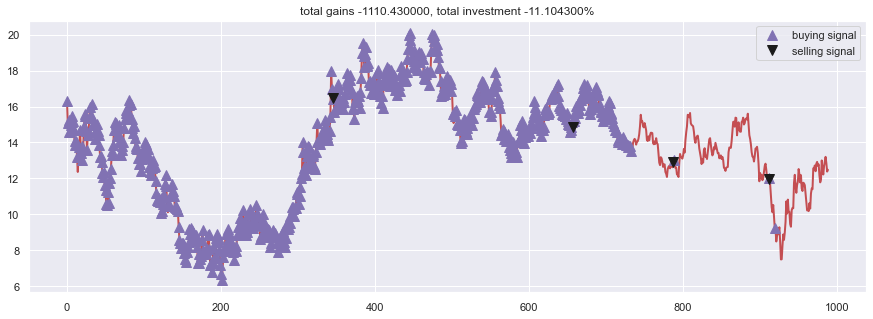

1398.工商銀行
5.454937
inventory:  [4.77]
epoch: 10, total rewards: 124.300043.3, cash in hand: 10119.530043, total money: 10124.160043
inventory:  [5.71, 5.87, 6.01, 5.99, 5.99, 5.13, 4.85, 4.79, 4.95, 4.76, 4.68, 4.56, 4.49, 3.96, 4.2, 3.86, 4.3, 4.12, 4.07, 4.39, 4.57, 5.02, 4.94, 4.98, 4.97, 5.19, 4.84, 4.44, 4.31, 4.17, 4.77, 4.77]
epoch: 20, total rewards: -70.231597.3, cash in hand: 9776.118403, total money: 9924.278403
inventory:  [6.171143, 5.788513, 5.75908, 5.935678, 5.778702, 5.611914, 5.739458, 5.700213, 5.503993, 5.513804, 5.710024, 5.592292, 5.660969, 5.592292, 5.719835, 5.582481, 5.405882, 5.317583, 5.415693, 5.425504, 5.494182, 5.474559, 5.592292, 5.543237, 5.327394, 5.38626, 5.660969, 5.749269, 5.690402, 5.798324, 5.719835, 5.739458, 5.67078, 5.700213, 5.778702, 5.788513, 5.798324, 5.768891, 5.798324, 5.867001, 5.788513, 5.788513, 5.729646, 5.788513, 5.680591, 5.611914, 5.553048, 5.660969, 5.57267, 5.582481, 5.454937, 5.464748, 5.454937, 5.57267, 5.494182, 5.533426, 5.621

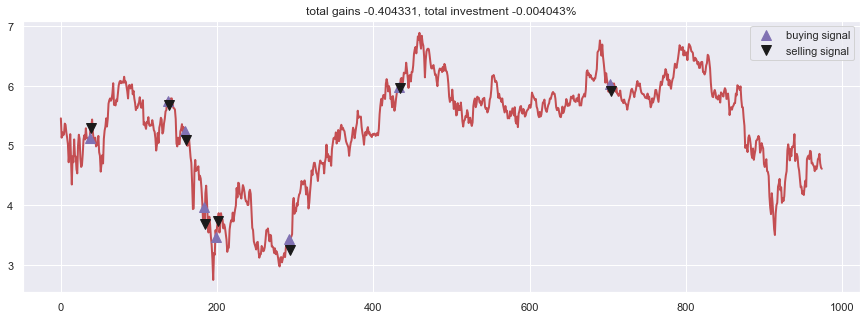

0016.新鴻基地產
166.899994
inventory:  [99.0]
epoch: 10, total rewards: 677.250012.3, cash in hand: 10578.250012, total money: 10676.650014
inventory:  []
epoch: 20, total rewards: -13.900002.3, cash in hand: 9986.099998, total money: 9986.099998
inventory:  []
epoch: 30, total rewards: 381.560112.3, cash in hand: 10381.560112, total money: 10381.560112
inventory:  [102.599998, 97.449997, 99.300003, 97.199997, 98.0, 103.699997, 104.199997, 102.900002, 106.099998, 109.599998, 108.400002, 104.599998, 107.099998, 103.599998, 107.199997, 106.900002, 105.599998, 107.0, 100.900002, 100.800003, 102.0, 100.599998, 98.449997, 97.199997, 96.199997, 94.400002, 95.25, 92.5, 91.300003, 95.849998]
epoch: 40, total rewards: 248.550010.3, cash in hand: 7211.650033, total money: 10163.650093
inventory:  [117.400002, 116.0, 116.300003, 117.699997, 117.400002, 101.5, 102.300003, 104.199997, 102.099998, 105.599998, 107.199997, 108.300003, 107.800003, 109.599998, 109.900002, 110.599998, 109.300003, 110.300003, 

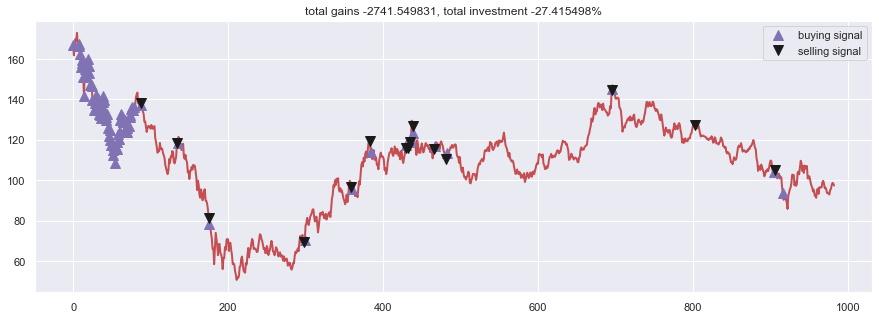

0525.廣深鐵路股份
5.63
inventory:  [3.3, 3.2, 3.23, 3.23, 3.2, 3.26, 3.24, 3.22, 3.25, 3.2, 3.18, 3.18, 3.23, 3.24, 3.23, 3.23, 3.19, 3.23, 3.25, 3.2, 3.16, 3.16, 3.1, 3.06, 3.13, 3.1, 3.15, 3.16, 3.15, 3.09, 3.05, 3.01, 2.92, 2.93, 2.94, 3.0, 3.04, 3.03, 3.03, 3.07, 3.0, 2.88, 2.8, 2.84, 2.91, 3.08, 3.18, 3.35, 3.28, 3.24, 3.23, 3.21, 3.25, 3.12, 3.09, 3.12, 3.24, 3.19, 3.13, 3.15, 3.17, 3.19, 3.19, 3.12, 3.29, 3.23, 3.17, 3.23, 3.21, 3.22, 3.23, 3.26, 3.32, 3.3, 3.29, 3.29, 3.24, 3.21, 3.24, 3.18, 3.15, 3.18, 3.2, 3.09, 3.07, 3.06, 3.05, 3.03, 3.01, 3.01, 2.79, 2.72, 2.69, 2.7, 2.8, 2.77, 2.73, 2.74, 2.78, 2.81, 2.77, 2.73, 2.71, 2.74, 2.73, 2.67, 2.73, 2.74, 2.66, 2.64, 2.62, 2.49, 2.37, 2.36, 2.41, 2.19, 2.23, 2.28, 2.25, 2.3, 2.44, 2.5, 2.58, 2.62, 2.72, 2.75, 2.7, 2.74, 2.7, 2.72, 2.79, 2.72, 2.76, 2.82]
epoch: 10, total rewards: -2.590000.3, cash in hand: 9598.210000, total money: 9954.650000
inventory:  [2.71, 2.72, 2.75, 2.72, 2.82]
epoch: 20, total rewards: -15.030000.3, cash in ha

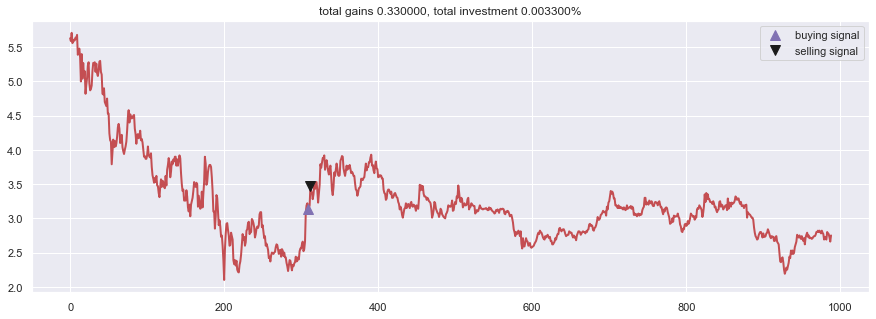

0011.恆生銀行
159.5
inventory:  [114.199997, 112.900002, 111.599998, 116.199997, 116.099998, 113.0, 109.5, 112.099998, 109.0, 109.400002, 108.099998, 110.0, 108.199997, 107.599998, 107.400002, 104.900002, 103.599998, 107.099998, 109.0, 108.099998, 109.800003, 110.599998, 109.599998, 108.599998, 107.599998, 107.699997, 107.199997, 107.900002, 108.199997, 108.199997, 111.0, 110.5, 111.599998, 112.0, 111.5, 112.0, 112.300003, 113.5, 113.0, 113.900002, 114.800003, 115.0, 115.800003, 116.800003, 116.5, 117.0, 117.400002, 116.699997, 116.199997, 116.800003, 116.300003, 116.400002, 116.300003, 116.0, 116.900002, 119.400002, 122.300003, 120.400002, 123.699997, 122.400002, 127.599998, 126.599998, 125.5, 127.699997, 130.699997, 128.199997, 122.5, 122.5, 122.099998, 122.599998, 122.300003, 122.599998, 122.5, 123.599998, 112.699997, 111.599998, 111.099998, 108.099998, 111.099998, 109.599998, 104.900002, 104.900002, 104.900002, 84.650002, 97.849998, 97.25, 97.599998, 99.199997, 96.449997]
epoch: 10, to

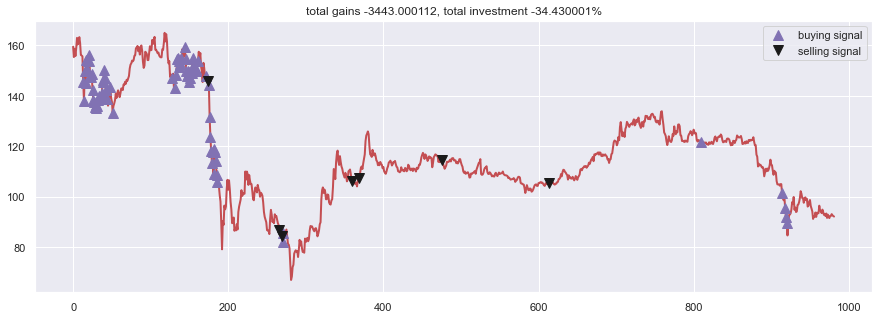

0006.電能實業
44.5
inventory:  [46.299999, 45.900002, 46.450001, 46.200001, 46.75, 46.25, 46.5, 46.549999, 46.900002, 46.700001, 47.200001, 48.200001, 48.599998, 49.549999, 47.150002, 46.400002, 46.0, 45.900002, 46.099998, 45.349998, 45.900002, 45.650002, 45.150002, 44.799999, 44.75, 44.950001, 45.0, 45.150002, 45.900002, 47.299999, 48.0, 48.599998, 47.799999, 47.700001, 47.0, 46.5, 46.049999, 46.349998, 46.5, 46.150002, 46.349998, 45.75, 45.799999, 46.099998, 46.0, 46.150002, 46.349998, 46.299999, 46.25, 46.0, 46.200001, 45.950001, 45.799999, 45.950001, 46.049999, 46.299999, 46.25, 46.200001, 46.450001, 46.0, 46.0, 46.950001, 48.049999, 47.799999, 48.150002, 47.900002, 47.400002, 47.049999, 49.200001, 49.299999, 49.799999, 49.450001, 50.650002, 48.900002, 49.25, 50.799999, 50.799999, 51.700001, 49.900002, 50.099998, 50.0, 50.0, 50.5, 50.150002, 49.599998, 49.450001, 49.200001, 49.349998, 49.849998, 49.25, 49.549999, 49.549999, 49.549999, 50.200001, 50.200001, 50.849998, 52.200001, 51.5, 5

inventory:  [49.950001, 49.950001, 49.650002, 50.049999, 49.950001, 50.0, 49.950001, 49.75, 50.0, 50.0, 49.700001, 49.950001, 50.0, 50.5, 50.150002, 49.75, 49.200001, 48.849998, 49.150002, 49.599998, 49.450001, 49.200001, 49.200001, 48.950001, 49.299999, 49.349998, 49.5, 49.5, 49.150002, 49.150002, 49.349998, 49.400002, 49.549999, 49.349998, 49.549999, 49.549999, 49.400002, 49.799999, 50.200001, 49.950001, 50.0, 50.099998, 50.049999, 52.200001, 51.5, 51.5, 51.099998, 51.299999, 50.849998, 51.200001, 51.099998, 51.25, 51.0, 51.200001, 51.150002, 51.049999, 50.150002, 50.849998, 51.450001, 52.150002, 52.0, 52.0, 52.299999, 52.799999, 52.799999, 52.549999, 52.549999, 52.900002, 53.700001, 53.599998, 53.049999, 54.299999, 54.049999, 53.849998, 54.049999, 53.75, 53.900002, 53.75, 55.25, 55.0, 55.0, 52.299999, 52.75, 52.599998, 52.450001, 54.25, 53.799999, 53.650002, 53.849998, 54.200001, 54.25, 53.5, 53.799999, 53.900002, 54.049999, 54.599998, 54.599998, 55.549999, 56.299999, 55.200001, 54.

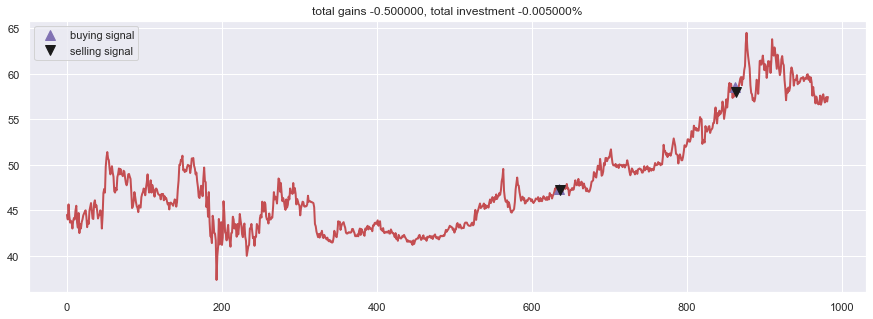

0001.長和
102.56205
inventory:  [50.673515, 50.101742, 51.030872, 50.387627, 47.814644, 47.707436, 47.493019, 51.459705, 52.317368, 54.390049, 51.423969, 54.997559, 54.318577, 54.783142, 56.677147, 55.247711, 53.996952, 55.354919, 56.605675, 54.818878, 52.674725, 54.068424, 62.39489, 63.288288, 62.680779, 62.037533, 60.893982, 60.572361, 61.751644, 59.42881, 60.608097, 61.179871, 60.03632, 59.321602, 59.321602, 63.466969, 65.039345, 68.362785, 68.469994, 67.326447, 68.327049, 67.505127, 68.291313, 65.396706, 67.147766, 65.36097, 65.289497, 63.96727, 61.6087, 61.358551, 61.465759, 62.216213, 64.932144, 66.004219, 63.681385, 62.359154, 62.287685, 61.78738, 61.322815, 60.03632, 61.00119, 61.108398, 59.571754, 61.644436, 63.002403, 63.18108, 66.039955, 69.720749, 69.32766, 68.541466, 70.971512, 73.473022, 70.363998, 70.399734, 71.543282, 69.649277, 69.256187, 70.757095, 67.862488, 69.256187, 69.470604, 68.577202, 69.970901, 68.934563, 67.898224, 68.970299, 67.11203, 69.899429, 70.399734, 71.

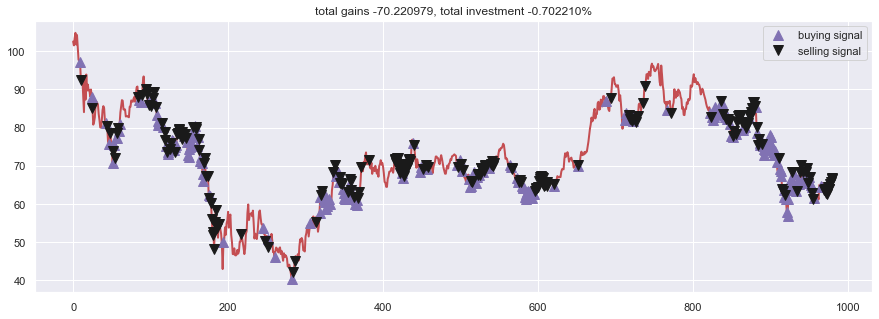

0384.中國燃氣
3.45
inventory:  [3.17, 3.27, 3.23, 3.25, 3.27, 3.23, 3.27, 3.27, 3.21, 3.15, 3.26, 3.21, 2.85, 3.08, 3.03, 3.0, 3.05, 3.04, 3.03, 3.14, 3.13, 3.1, 3.05, 3.22, 3.15, 3.14, 3.16, 3.04, 3.0, 2.96, 3.02, 3.0, 3.01, 2.99, 2.93, 2.94, 2.81, 2.72, 2.32, 2.18, 2.23, 2.34, 2.46, 2.52, 2.57, 2.6, 2.48, 2.51, 2.61, 2.56, 2.6, 2.66, 2.62, 2.53, 2.52, 2.62, 2.55, 2.31, 2.02, 1.75, 1.91, 1.99, 1.92, 1.74, 1.8, 1.9, 2.07, 2.21, 2.35, 2.31, 2.26, 2.07, 2.15, 2.16, 2.26, 2.2, 2.33, 2.37, 2.37, 2.37, 2.82, 2.61, 2.64, 2.56, 2.6, 2.71, 2.67, 2.77, 2.78, 2.77, 2.65, 2.69, 2.76, 2.9, 2.88, 2.8, 2.8]
epoch: 10, total rewards: 11.030000.3, cash in hand: 9750.940000, total money: 10096.260000
inventory:  [1.8, 1.92, 1.96, 2.02, 1.8, 1.63, 1.75, 1.94, 1.83, 1.75, 1.91, 1.99, 1.92, 1.97, 1.78, 1.8, 1.74, 1.8, 1.9, 2.07, 2.21, 2.35, 2.31, 2.26, 2.07, 2.15, 2.16, 2.26, 2.2, 2.33, 2.37, 2.37, 2.82, 2.61, 2.64, 2.56, 2.6, 2.71, 2.67, 2.77, 2.78, 2.77, 2.65, 2.76, 2.9, 2.88, 2.8, 2.8]
epoch: 20, total rew

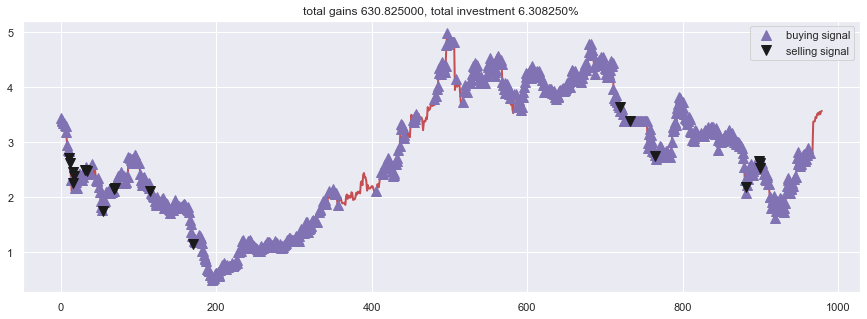

0002.中電控股
53.900002
inventory:  [52.650002, 52.599998, 52.5, 52.75, 53.25, 53.25, 52.549999, 52.049999, 52.349998, 52.299999, 52.150002, 52.5, 51.900002, 52.599998, 52.400002, 52.200001, 52.299999, 52.200001, 52.450001, 52.400002, 52.150002, 52.299999, 52.299999, 52.299999, 52.549999, 52.099998, 52.049999, 52.200001, 52.049999, 52.599998, 52.0, 52.0, 52.049999, 52.0, 52.400002, 52.25, 52.200001, 52.450001, 52.5, 52.599998, 52.700001, 52.200001, 52.299999, 52.049999, 52.150002, 51.849998, 51.900002, 52.099998, 52.0, 51.700001, 52.0, 51.900002, 52.099998, 52.75, 52.75, 52.75, 52.549999, 52.549999, 52.900002, 52.0, 51.849998, 51.849998, 52.099998, 52.150002, 52.349998, 52.349998, 52.349998, 52.450001, 52.450001, 53.049999, 52.700001, 52.950001, 52.700001, 52.599998, 52.5, 52.349998, 52.950001, 53.0, 52.700001, 53.0, 52.799999, 53.049999, 53.349998, 52.900002, 53.299999, 53.25, 53.650002, 53.900002, 53.650002, 54.25, 54.25, 54.400002, 54.450001, 54.900002, 54.75, 55.099998, 55.150002, 54.8

inventory:  []
epoch: 90, total rewards: 23.049999.3, cash in hand: 10023.049999, total money: 10023.049999
inventory:  [56.849998, 57.200001, 57.099998, 56.25, 56.900002, 54.299999, 54.599998, 54.299999, 54.849998, 54.450001, 54.349998, 54.700001, 55.0, 54.849998, 55.0, 55.549999, 55.799999, 56.400002, 55.400002, 55.25, 55.25, 54.75, 54.799999, 54.849998, 55.200001, 54.799999, 54.75, 54.549999, 54.299999, 54.5, 54.950001, 55.049999, 55.400002, 55.400002, 55.349998, 56.099998, 55.950001, 56.349998, 56.349998, 56.900002, 56.849998, 56.349998, 56.450001, 56.549999, 56.599998, 57.299999, 57.099998, 57.349998, 57.5, 57.349998, 56.849998, 57.049999, 56.849998, 56.900002, 56.650002, 56.650002, 56.549999, 56.75, 57.349998, 57.700001, 57.599998, 57.700001, 57.5, 57.900002, 57.25, 57.400002, 57.5, 57.450001, 57.150002, 58.049999, 57.900002, 57.849998, 57.700001, 57.5, 57.950001, 57.450001, 57.799999, 58.200001, 58.950001, 59.599998, 59.549999, 59.299999, 59.5, 58.599998, 59.650002, 59.950001, 5

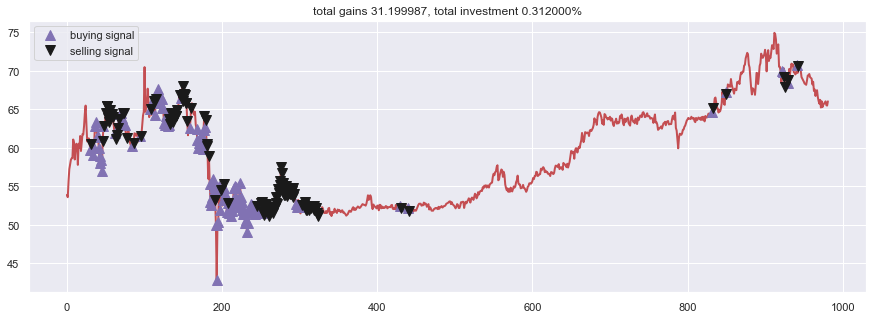

2388.中銀香港
21.4
inventory:  [11.14, 12.34, 13.24, 13.22, 13.96, 14.28, 14.16, 13.56, 13.02, 13.9, 13.68, 13.72, 13.32, 13.06, 13.08, 13.04, 13.24, 12.98, 12.32, 12.74, 12.72, 13.2, 13.26, 13.58, 13.9, 14.24, 14.48, 14.36, 13.9, 13.8, 13.88, 13.56, 14.16, 14.28, 13.96, 14.64, 15.06, 15.2, 15.16, 15.54, 16.18, 15.96, 16.02, 16.5, 16.52, 16.08, 15.76, 15.42, 15.24, 14.9, 15.32, 15.9, 15.3, 15.54, 15.48, 14.92, 14.92, 14.74, 14.96, 14.9, 15.44, 15.7, 15.72, 15.12, 16.0, 15.54, 15.72, 15.5, 15.68, 16.200001, 16.68, 16.9, 16.719999, 16.799999, 16.860001, 16.940001, 17.08, 17.559999, 18.559999, 17.24, 17.540001, 17.700001, 17.200001, 17.24, 17.1, 16.700001, 17.120001, 17.0, 16.68, 16.360001, 16.540001, 16.940001, 17.4, 17.42, 17.219999, 17.02, 17.6, 17.66, 17.34, 18.08, 18.139999, 17.700001, 17.98, 18.219999, 17.98, 17.959999, 17.780001, 18.24, 17.959999, 18.120001, 18.34, 17.879999, 18.459999, 18.92, 18.959999, 19.559999, 19.780001, 19.459999, 19.6, 19.48, 19.24, 19.139999, 18.799999, 19.02, 

inventory:  [18.0, 17.1, 17.120001, 17.139999, 17.200001, 16.879999, 16.84, 16.66, 16.620001, 16.540001, 16.5, 17.34, 17.139999, 17.08, 17.219999, 17.24, 17.58, 17.66, 17.299999, 17.700001, 17.6, 17.66, 17.82, 17.780001, 17.76, 18.52, 18.6, 18.68, 18.76, 20.5, 20.75, 20.4, 20.049999, 20.200001, 20.950001, 20.85, 20.549999, 21.299999, 22.299999, 22.700001, 22.75, 22.75, 22.700001, 23.5, 25.4, 25.200001, 24.450001, 25.950001, 25.9, 25.85, 25.799999, 27.65, 26.6, 26.25, 25.85, 25.15, 25.0, 25.450001, 24.75, 24.299999, 23.950001, 22.950001, 23.549999, 23.75, 23.799999, 24.15, 23.950001, 24.200001, 24.1, 23.35, 23.6, 23.35, 23.6, 24.15, 24.799999, 24.75, 24.700001, 24.9, 24.85, 24.549999, 22.799999, 23.25, 23.15, 22.200001, 22.9, 23.35, 23.15, 20.799999, 19.58, 19.139999, 18.74, 18.360001, 19.299999, 19.540001, 20.4, 20.200001, 19.52, 19.860001, 19.42, 20.0, 19.860001, 19.08, 16.700001, 14.52, 16.76, 17.76, 18.360001, 18.32, 18.4, 18.92, 19.16, 18.219999, 18.18, 18.32, 17.68, 17.58, 16.6399

inventory:  [8.98, 9.33, 9.31, 9.25, 9.09, 9.5, 10.6, 10.78, 10.62, 10.5, 10.8, 10.6, 10.6, 11.0, 11.0, 10.66, 10.36, 10.64, 11.06, 11.4, 11.34, 11.66, 11.74, 11.9, 11.8, 11.2, 11.26, 11.0, 11.0, 11.08, 13.24, 14.28, 13.32, 23.75]
epoch: 100, total rewards: 3.180001.3, cash in hand: 9618.530001, total money: 10240.050035
close[-1]: 18.4


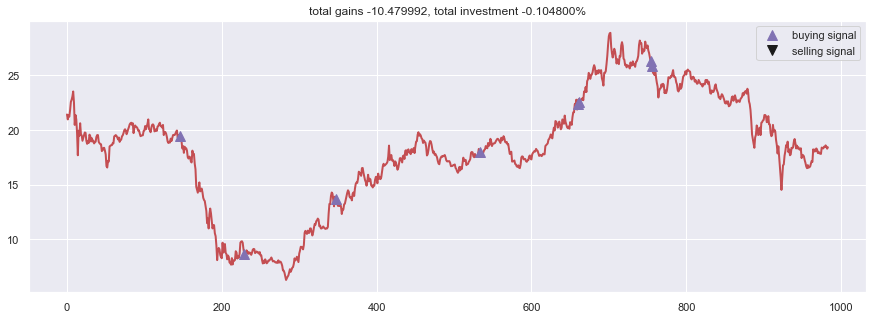

3968.招商銀行
22.201851
inventory:  [19.427361, 19.691214, 19.740074, 18.196051, 18.098328, 17.433809, 17.492443, 18.000603, 17.824701, 17.922424, 18.801933, 17.981058, 18.215593, 19.310095, 19.88666, 19.740074, 19.935522, 19.984383, 19.466452, 19.691214, 19.837799, 19.88666, 20.033245, 20.179831, 20.228691, 20.766169, 21.303646, 20.766169, 20.668446, 20.815029, 21.059338, 20.473, 20.473, 20.228691, 20.570723, 20.619583, 20.717306, 20.424137, 20.717306, 20.668446, 20.912752, 20.766169, 20.619583, 21.010475, 20.130968, 19.935522, 19.544628, 19.114647, 19.329638, 19.368729, 19.349182, 19.016924, 19.036469, 18.762844, 19.153736, 19.368729, 18.841022, 18.860567, 18.880112, 18.977835, 19.466452, 18.645576, 18.567398, 18.039694, 18.078781, 18.391497, 18.039694, 17.570621, 17.668344, 18.48922, 18.528309, 18.332863, 18.37195, 18.645576, 18.411041, 17.629255, 17.590166, 17.726978, 17.726978, 18.020147, 18.039694, 18.469675, 18.215593, 18.45013, 18.469675, 18.215593, 18.078781, 18.293774, 17.531532,

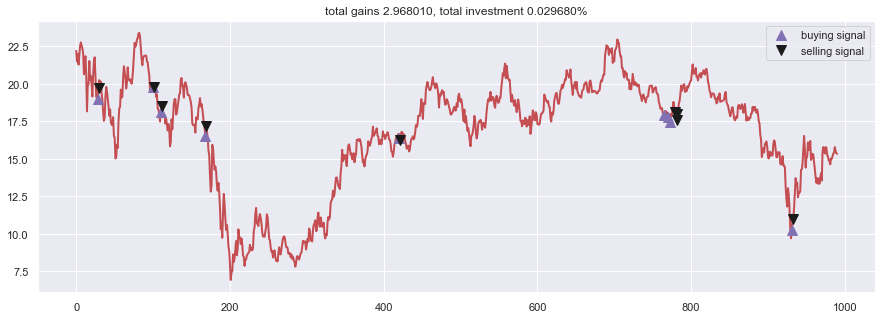

1211.比亞迪股份
13.68421
inventory:  [44.799999, 42.799999, 42.400002, 41.799999, 42.700001, 42.400002, 46.150002, 46.650002, 46.349998, 45.75, 45.0, 48.599998, 50.5, 56.299999, 58.400002, 55.599998, 56.849998, 63.0, 63.349998, 60.700001, 68.25, 72.300003, 72.949997, 73.599998, 76.599998, 79.550003, 83.0, 83.199997, 82.449997, 83.300003, 85.5, 85.199997, 81.650002, 76.650002, 72.400002, 76.0, 71.5, 73.099998, 72.199997, 70.800003, 71.800003, 69.379997, 62.799999, 63.900002, 69.800003, 66.550003, 63.549999, 65.0, 66.190002, 68.75, 66.5, 68.5, 69.800003, 70.559998, 67.800003, 65.650002, 65.580002, 67.82, 68.230003, 64.650002, 64.720001, 63.950001, 62.220001, 65.150002, 62.759998, 58.599998, 56.799999, 53.650002, 53.650002, 56.529999, 59.299999, 59.799999, 60.450001, 59.049999, 55.799999, 56.66, 56.630001, 57.950001, 61.0, 60.849998, 60.709999, 60.400002, 62.009998, 65.389999, 65.949997, 64.400002, 63.450001, 64.93, 66.150002, 66.82, 70.5, 69.5, 69.629997, 74.550003, 75.199997, 75.389999, 77.3

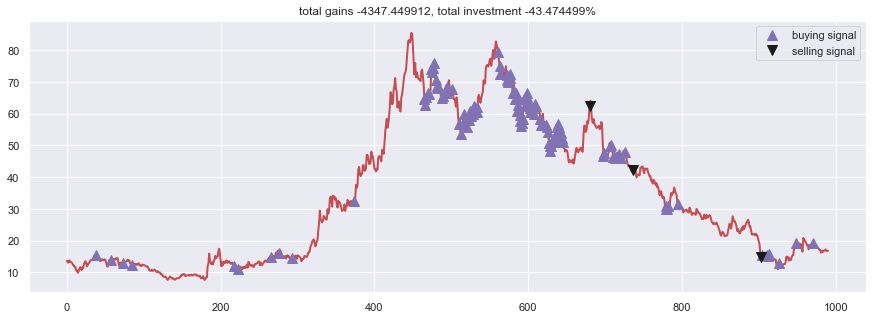

0522.ASM太平洋
59.049999
inventory:  [64.25, 63.75, 62.799999, 64.650002, 66.699997, 66.050003, 66.550003, 66.050003, 66.5, 66.0, 67.699997, 70.050003, 69.199997, 71.300003, 71.449997, 70.599998, 70.699997, 69.5, 69.300003, 73.650002, 73.199997, 71.099998, 69.949997, 70.5, 70.199997, 71.949997, 72.400002, 71.199997, 72.699997, 71.449997, 73.599998, 73.5, 76.599998, 87.25, 86.449997, 85.0, 84.400002, 83.0, 82.949997, 86.050003, 86.699997, 86.099998, 98.25, 100.199997, 97.25, 95.949997, 97.949997, 97.849998, 99.599998, 99.75, 103.5, 105.699997, 103.0, 95.050003, 94.5, 95.300003, 97.599998, 105.900002, 104.0, 106.699997, 102.300003, 102.900002, 103.900002, 100.800003, 99.550003, 102.0, 94.099998, 97.550003, 105.099998, 111.0, 111.300003, 103.0, 102.300003, 105.900002, 104.300003, 100.900002, 102.5, 103.0, 102.699997, 101.800003, 101.400002, 106.5, 103.900002, 106.800003, 106.300003, 104.699997, 107.199997, 109.800003, 107.699997, 93.800003, 89.849998, 89.599998, 86.900002, 78.199997, 74.8000

inventory:  [71.0, 73.949997, 59.200001, 61.5, 61.0, 64.349998, 64.599998, 64.150002, 62.150002, 61.650002, 60.150002, 62.299999, 63.799999, 61.549999, 63.700001, 62.400002, 64.0, 64.050003, 63.900002, 64.25, 64.699997, 61.400002, 61.25, 61.700001, 61.150002, 62.349998, 64.75, 64.400002, 64.800003, 71.550003, 71.0, 73.550003, 71.150002, 71.349998, 71.150002, 71.699997, 71.199997, 68.550003, 65.050003, 65.800003, 66.150002, 67.099998, 62.950001, 64.650002, 64.5, 65.0, 65.650002, 66.050003, 66.550003, 66.050003, 65.949997, 66.5, 66.0, 67.0, 67.699997, 68.0, 69.550003, 69.0, 70.050003, 69.199997, 72.300003, 69.050003, 70.099998, 71.300003, 72.849998, 72.5, 71.400002, 70.599998, 70.199997, 71.449997, 70.599998, 70.699997, 69.5, 69.300003, 69.900002, 68.849998, 68.25, 71.099998, 72.449997, 73.650002, 71.900002, 72.0, 73.199997, 71.099998, 69.949997, 70.5, 71.150002, 70.199997, 71.949997, 72.949997, 72.400002, 72.199997, 71.199997, 72.699997, 71.449997, 72.300003, 73.599998, 73.5, 86.050003,

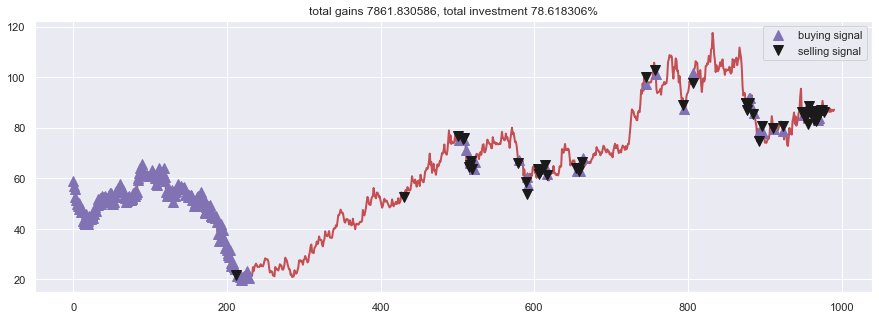

In [16]:
# portfolio = ["0003.香港中華煤氣","0012.恆基地產","0388.香港交易所","0700.騰訊控股","2382.舜宇光學科技","0066.港鐵公司"]
for stock in range(len(portfolio)):
    df = pd.read_csv("./train_data_2008-2011/%s.csv" % (portfolio[stock]))
    df = df.dropna(axis=0,how="any")
    close = df.Close.values.tolist()
    print(portfolio[stock])
    print(close[0])
#     portfolio = {"0003.香港中華煤氣_2021_days_train":close}
    initial_money = 10000
    window_size = 30
    batch_size = 64
    agent = Agent(state_size = window_size, 
                  window_size = window_size, 
                  stock_name = portfolio[stock],
                  trend = close, 
                  batch_size = batch_size)
    agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

    states_buy, states_sell, total_money, total_gains, invest = agent.buy(initial_money = initial_money)
    
    fig = plt.figure(figsize = (15,5))
    plt.plot(close, color='r', lw=2.)
    plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    # plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

Day 0: buy 1 unit at price 9.243139, cash in hand 9990.756861
Day 1: buy 1 unit at price 9.243139, cash in hand 9981.513722
Day 2: buy 1 unit at price 9.131626, cash in hand 9972.382096
Day 3: buy 1 unit at price 9.106846, cash in hand 9963.275250
Day 4: buy 1 unit at price 9.119236, cash in hand 9954.156014
Day 5: buy 1 unit at price 8.970553, cash in hand 9945.185461
Day 6: buy 1 unit at price 8.920992, cash in hand 9936.264469
Day 7: buy 1 unit at price 8.970553, cash in hand 9927.293916
Day 8: buy 1 unit at price 9.032504, cash in hand 9918.261412
Day 9: buy 1 unit at price 9.007723, cash in hand 9909.253689
Day 10: buy 1 unit at price 8.933382, cash in hand 9900.320307
Day 11: buy 1 unit at price 8.958162, cash in hand 9891.362145
Day 12: buy 1 unit at price 8.673186, cash in hand 9882.688959
Day 13: buy 1 unit at price 8.313868, cash in hand 9874.375091
Day 14: buy 1 unit at price 8.375820, cash in hand 9865.999271
Day 15: buy 1 unit at price 8.313868, cash in hand 9857.685403
Da

Day 146: buy 1 unit at price 9.922125, cash in hand 8686.465763
Day 147: buy 1 unit at price 9.908496, cash in hand 8676.557267
Day 148: buy 1 unit at price 9.881237, cash in hand 8666.676030
Day 149: buy 1 unit at price 9.908496, cash in hand 8656.767534
Day 150: buy 1 unit at price 9.949384, cash in hand 8646.818150
Day 151: buy 1 unit at price 10.003901, cash in hand 8636.814249
Day 152: buy 1 unit at price 9.949384, cash in hand 8626.864865
Day 153: buy 1 unit at price 9.908496, cash in hand 8616.956369
Day 154: buy 1 unit at price 9.867608, cash in hand 8607.088761
Day 155: buy 1 unit at price 9.853979, cash in hand 8597.234782
Day 156: buy 1 unit at price 9.935754, cash in hand 8587.299028
Day 157: buy 1 unit at price 9.922125, cash in hand 8577.376903
Day 158: buy 1 unit at price 9.867608, cash in hand 8567.509295
Day 159: buy 1 unit at price 9.894867, cash in hand 8557.614428
Day 160: buy 1 unit at price 9.935754, cash in hand 8547.678674
Day 161: buy 1 unit at price 9.949384, 

Day 316: buy 1 unit at price 10.753512, cash in hand 7002.089610
Day 317: buy 1 unit at price 10.480926, cash in hand 6991.608684
Day 318: buy 1 unit at price 10.385521, cash in hand 6981.223163
Day 319: buy 1 unit at price 10.480926, cash in hand 6970.742237
Day 320: buy 1 unit at price 10.480926, cash in hand 6960.261311
Day 321: buy 1 unit at price 10.467297, cash in hand 6949.794014
Day 322: buy 1 unit at price 10.480926, cash in hand 6939.313088
Day 323: buy 1 unit at price 10.535443, cash in hand 6928.777645
Day 324: buy 1 unit at price 10.535443, cash in hand 6918.242202
Day 325: buy 1 unit at price 10.589961, cash in hand 6907.652241
Day 326: buy 1 unit at price 10.562702, cash in hand 6897.089539
Day 327: buy 1 unit at price 10.603590, cash in hand 6886.485949
Day 328: buy 1 unit at price 10.535443, cash in hand 6875.950506
Day 329: buy 1 unit at price 10.562702, cash in hand 6865.387804
Day 330: buy 1 unit at price 10.671736, cash in hand 6854.716068
Day 331: buy 1 unit at pr

Day 464: buy 1 unit at price 11.079252, cash in hand 5383.932742
Day 465: buy 1 unit at price 11.094244, cash in hand 5372.838498
Day 466: buy 1 unit at price 11.034275, cash in hand 5361.804223
Day 467: buy 1 unit at price 11.064260, cash in hand 5350.739963
Day 468: buy 1 unit at price 11.094244, cash in hand 5339.645719
Day 469: buy 1 unit at price 11.154213, cash in hand 5328.491506
Day 470: buy 1 unit at price 11.214182, cash in hand 5317.277324
Day 471: buy 1 unit at price 11.334120, cash in hand 5305.943204
Day 472: buy 1 unit at price 11.454058, cash in hand 5294.489146
Day 473: buy 1 unit at price 11.454058, cash in hand 5283.035088
Day 474: buy 1 unit at price 11.424073, cash in hand 5271.611015
Day 475: buy 1 unit at price 11.544011, cash in hand 5260.067004
Day 476: buy 1 unit at price 11.588988, cash in hand 5248.478016
Day 477: buy 1 unit at price 11.618972, cash in hand 5236.859044
Day 478: buy 1 unit at price 11.544011, cash in hand 5225.315033
Day 479: buy 1 unit at pr

Day 624: buy 1 unit at price 12.665429, cash in hand 3496.914212
Day 625: buy 1 unit at price 12.780869, cash in hand 3484.133343
Day 626: buy 1 unit at price 12.978767, cash in hand 3471.154576
Day 627: buy 1 unit at price 13.028241, cash in hand 3458.126335
Day 628: buy 1 unit at price 13.374561, cash in hand 3444.751774
Day 629: buy 1 unit at price 13.374561, cash in hand 3431.377213
Day 630: buy 1 unit at price 13.391053, cash in hand 3417.986160
Day 631: buy 1 unit at price 13.308596, cash in hand 3404.677564
Day 632: buy 1 unit at price 13.275613, cash in hand 3391.401951
Day 633: buy 1 unit at price 13.292104, cash in hand 3378.109847
Day 634: buy 1 unit at price 13.308596, cash in hand 3364.801251
Day 635: buy 1 unit at price 13.209647, cash in hand 3351.591604
Day 636: buy 1 unit at price 13.044733, cash in hand 3338.546871
Day 637, sell 1 unit at price 12.764378, investment 40.162445 %, cash in hand 3351.311249,
Day 638: buy 1 unit at price 12.846835, cash in hand 3338.464414

Day 749: buy 1 unit at price 13.819830, cash in hand 1959.251935
Day 750: buy 1 unit at price 13.786848, cash in hand 1945.465087
Day 751: buy 1 unit at price 13.770356, cash in hand 1931.694731
Day 752: buy 1 unit at price 13.770356, cash in hand 1917.924375
Day 753: buy 1 unit at price 13.836322, cash in hand 1904.088053
Day 754: buy 1 unit at price 13.852813, cash in hand 1890.235240
Day 755: buy 1 unit at price 13.951762, cash in hand 1876.283478
Day 756: buy 1 unit at price 14.001236, cash in hand 1862.282242
Day 757: buy 1 unit at price 14.116676, cash in hand 1848.165566
Day 758: buy 1 unit at price 14.100185, cash in hand 1834.065381
Day 759: buy 1 unit at price 14.116676, cash in hand 1819.948705
Day 760: buy 1 unit at price 14.083694, cash in hand 1805.865011
Day 761: buy 1 unit at price 14.034219, cash in hand 1791.830792
Day 762: buy 1 unit at price 14.100185, cash in hand 1777.730607
Day 763: buy 1 unit at price 14.083694, cash in hand 1763.646913
Day 764: buy 1 unit at pr

Day 895: buy 1 unit at price 14.693877, cash in hand 80.592740
Day 896: buy 1 unit at price 14.167800, cash in hand 66.424940
Day 897: buy 1 unit at price 14.367346, cash in hand 52.057594
Day 898, sell 1 unit at price 14.077097, investment 71.622605 %, cash in hand 66.134691,
Day 899: buy 1 unit at price 14.004535, cash in hand 52.130156
Day 900: buy 1 unit at price 13.877551, cash in hand 38.252605
Day 901: buy 1 unit at price 13.986394, cash in hand 24.266211
Day 902: buy 1 unit at price 13.732426, cash in hand 10.533785
Day 903, sell 1 unit at price 13.514739, investment 61.833025 %, cash in hand 24.048524,
Day 904, sell 1 unit at price 13.605442, investment 61.244504 %, cash in hand 37.653966,
Day 905, sell 1 unit at price 14.077097, investment 69.573382 %, cash in hand 51.731063,
Day 906: buy 1 unit at price 13.931972, cash in hand 37.799091
Day 907: buy 1 unit at price 14.022675, cash in hand 23.776416
Day 908: buy 1 unit at price 14.131519, cash in hand 9.644897
Day 916, sell 1

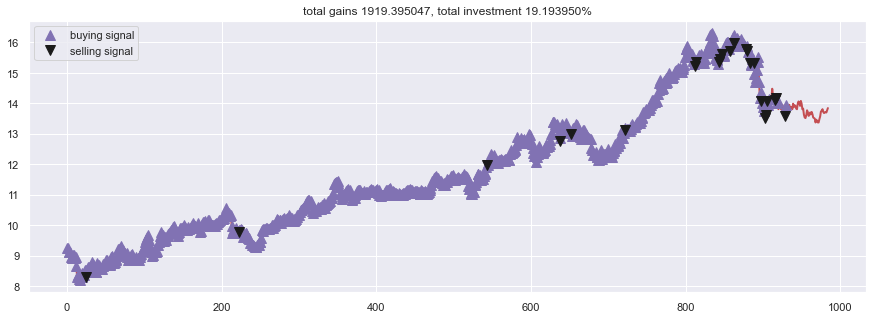

In [161]:
# states_buy, states_sell, total_money, total_gains, invest = agent.buy(initial_money = initial_money)
    
# fig = plt.figure(figsize = (15,5))
# plt.plot(close, color='r', lw=2.)
# plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
# plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
# plt.legend()
# plt.show()

# Load the models for testing

2382.舜宇光學科技


2022-05-28 20:33:30.633126: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 20:33:30.634321: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


close[-1]: 69.599998


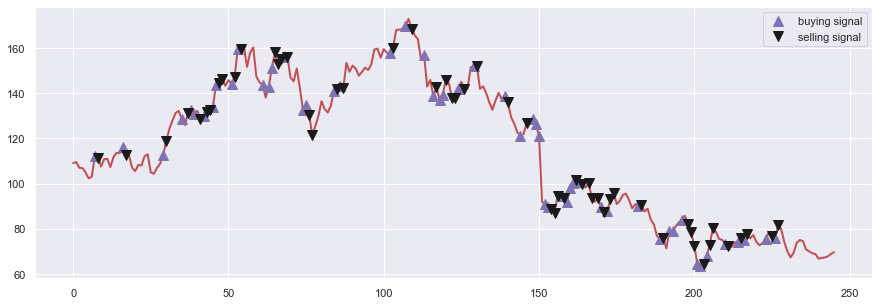

0700.騰訊控股
close[-1]: 314.0


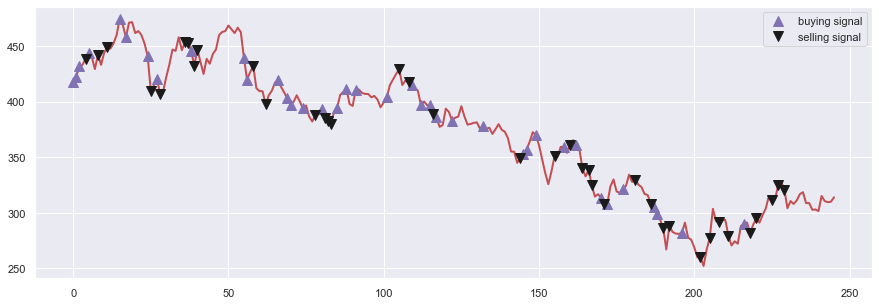

0002.中電控股
close[-1]: 88.5


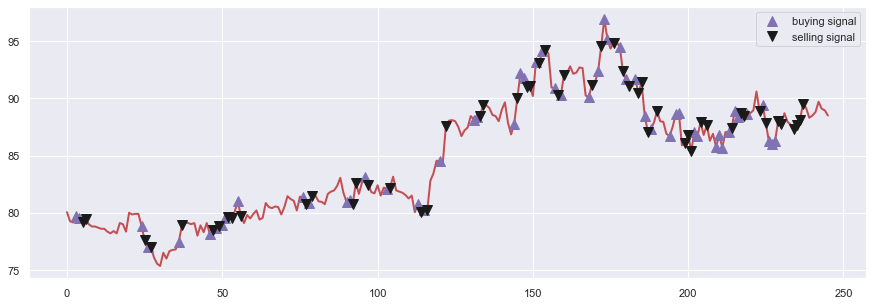

0066.港鐵公司
close[-1]: 41.200001


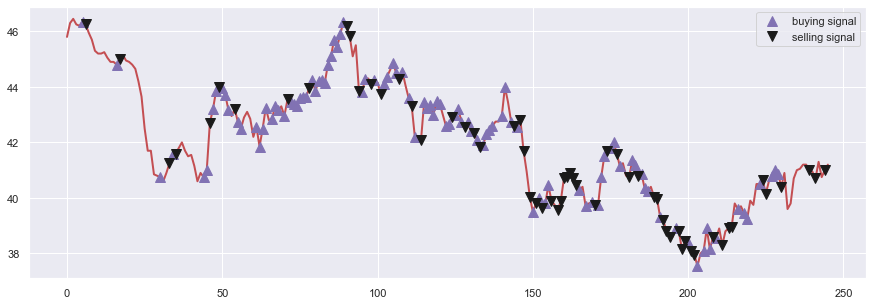

1211.比亞迪股份
close[-1]: 49.950001


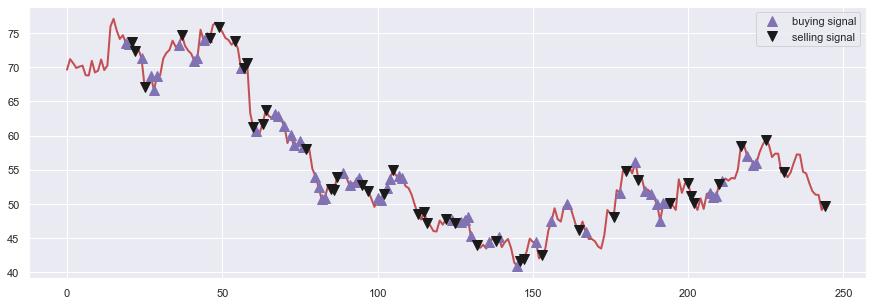

0388.香港交易所
close[-1]: 226.600006


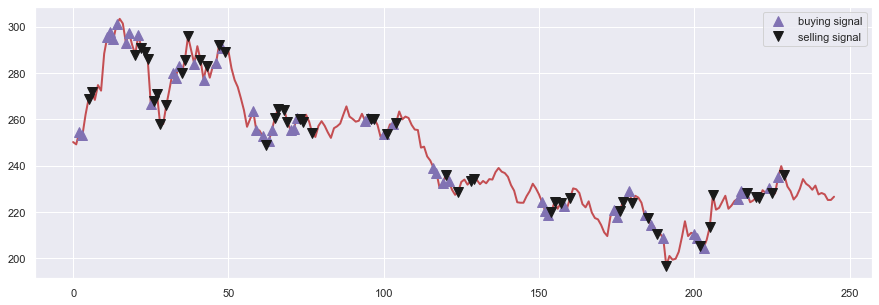

,2382.舜宇光學科技,0700.騰訊控股,0002.中電控股,0066.港鐵公司,1211.比亞迪股份,0388.香港交易所
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,1
3,0,0,1,0,0,1
4,0,-1,1,0,0,0
...,...,...,...,...,...,...
241,0,0,0,-1,0,0
242,0,0,0,0,0,0
243,0,0,0,0,0,0
244,0,0,0,-1,-1,0


In [4]:

# low risk
# portfolio = ["0003.香港中華煤氣","0700.騰訊控股","0002.中電控股","0066.港鐵公司","0011.恆生銀行","0388.香港交易所"]
# medium risk
# portfolio = ["2688.新奧能源","0700.騰訊控股","0002.中電控股","0066.港鐵公司","2388.中銀香港","0388.香港交易所"]
# high risk
portfolio = ["2382.舜宇光學科技","0700.騰訊控股","0002.中電控股","0066.港鐵公司","1211.比亞迪股份","0388.香港交易所"]

df_test = pd.read_csv("./DQN_test_data/2013-2022/%s.csv" % (portfolio[0]))
df_test = df_test[df_test['Date']>="2018-01-01"]
df_test = df_test[df_test['Date']<="2019-01-01"]
df_test = df_test.dropna(axis=0,how="any")

close = df_test.Close.values.tolist()

# df_trade store the actions of each stock, 0:hold, 1:buy, -1:sell 
df_trade = pd.DataFrame(index=np.arange(len(close)),columns=portfolio)
df_trade = df_trade.fillna(0)

df_close = pd.DataFrame(columns=portfolio)

for stock in range(len(portfolio)):
    print(portfolio[stock])
    df_test = pd.read_csv("./DQN_test_data/2013-2022/%s.csv" % (portfolio[stock]))
    df_test = df_test[df_test['Date']>="2018-01-01"]
    df_test = df_test[df_test['Date']<="2019-01-01"]
    df_test = df_test.dropna(axis=0,how="any")
    close = df_test.Close.values.tolist()
    df_close[portfolio[stock]] = close
    
    initial_money = 10000
    window_size = 30
    batch_size = 64
    agent = Agent(state_size = window_size, 
                  window_size = window_size, 
                  stock_name = portfolio[stock],
                  trend = close, 
                  batch_size = batch_size,
                  existed_model=True)
    states_buy, states_sell, total_money, total_gains, invest = agent.buy(initial_money = initial_money)

    df_trade.loc[states_buy,portfolio[stock]] = 1
    df_trade.loc[states_sell,portfolio[stock]] = -1
    
    fig = plt.figure(figsize = (15,5))
    plt.plot(close, color='r', lw=2.)
    plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    # plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

df_trade

# Test 3 different risk-level portfolio by applying 3 traing strategies and compare their performance.
# 1st strategy: use all cash to buy the stocks in lots evenly that the DRL model suggests to buy and sell all the lots of the stocks that the DRL model suggests to sell
# 2nd strategy: use all cash to buy the stocks in lots evenly that the DRL model suggests to buy and sell half of the lots of the stocks that the DRL model suggests to sell. If the number of lots of the stocks is an odd number after halving in the second strategy, we round up the number.
# 3rd strategy: buy and hold

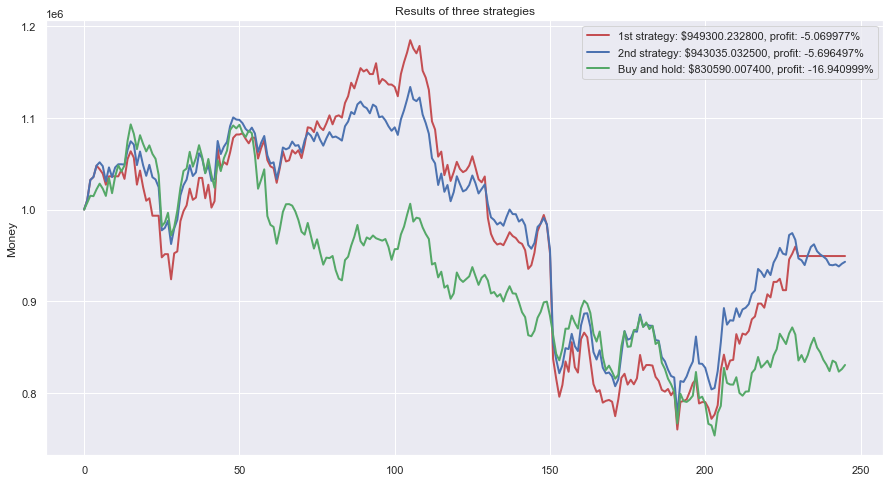

In [5]:
# low risk
# portfolio = ["0003.香港中華煤氣","0700.騰訊控股","0002.中電控股","0066.港鐵公司","0011.恆生銀行","0388.香港交易所"]
# medium risk
# portfolio = ["2688.新奧能源","0700.騰訊控股","0002.中電控股","0066.港鐵公司","2388.中銀香港","0388.香港交易所"]
# high risk
portfolio = ["2382.舜宇光學科技","0700.騰訊控股","0002.中電控股","0066.港鐵公司","1211.比亞迪股份","0388.香港交易所"]

# low risk
# lot_dict = {"0003.香港中華煤氣":1000, "0700.騰訊控股":100,"0002.中電控股":500,"0066.港鐵公司":500, "0011.恆生銀行":100,"0388.香港交易所":100}
# medium risk
# lot_dict = {"2688.新奧能源":100, "0700.騰訊控股":100,"0002.中電控股":500,"0066.港鐵公司":500, "2388.中銀香港":500,"0388.香港交易所":100}
# high risk
lot_dict = {"2382.舜宇光學科技":100, "0700.騰訊控股":100,"0002.中電控股":500,"0066.港鐵公司":500, "1211.比亞迪股份":500,"0388.香港交易所":100}

# proportion of each stock, generated by GA.
# low risk
# ga_result = {"0003.香港中華煤氣":7.96, "0700.騰訊控股":8.29,"0002.中電控股":36.82,"0066.港鐵公司":20.42, "0011.恆生銀行":23.28,"0388.香港交易所":3.23}
# medium risk
# ga_result = {"2688.新奧能源":6.65, "0700.騰訊控股":30.07,"0002.中電控股":20.54,"0066.港鐵公司":21.71, "2388.中銀香港":7.54,"0388.香港交易所":10.49}
# high risk
ga_result = {"2382.舜宇光學科技":6.43, "0700.騰訊控股":37.64,"0002.中電控股":16.08,"0066.港鐵公司":5.67, "1211.比亞迪股份":23.39,"0388.香港交易所":10.8}

buy_and_hold_asset = 0
buy_and_hold_cash = 1000000
buy_and_hold_list = []
buy_and_hold_shares_dict = {}
for stock in range(len(portfolio)):
    buy_and_hold_shares_dict[portfolio[stock]] = 0

for col in df_close.columns:
    initial_money = 1000000
    buy_cash = ga_result[col]*initial_money/100
    lot_can_buy = buy_cash//(df_close[col].loc[0]*lot_dict[col])
    buy_and_hold_shares_dict[col] = lot_can_buy*lot_dict[col]
    buy_and_hold_cash -= lot_can_buy*lot_dict[col]*df_close[col].loc[0]
    
    
cash = 1000000

portfolio_dict = {}
for stock in range(len(portfolio)):
    portfolio_dict[portfolio[stock]] = 0

shares_dict = {}
for stock in range(len(portfolio)):
    shares_dict[portfolio[stock]] = 0

result_1 = []
result_2 = []
asset = 0

for i in range(2):
    cash = 1000000

    portfolio_dict = {}
    for stock in range(len(portfolio)):
        portfolio_dict[portfolio[stock]] = 0

    shares_dict = {}
    for stock in range(len(portfolio)):
        shares_dict[portfolio[stock]] = 0
        
    asset = 0
    
    for index, row in df_trade.iterrows():

        # update the assets of portfolio each time
        for col in df_close.columns:
            portfolio_dict[col] = shares_dict[col]*df_close[col][index]
            
        # sell all the sell-stocks first before buying other stocks
        for col in df_trade.loc[index][df_trade.loc[index]==-1].to_frame().index:
            if i == 0:
                cash += shares_dict[col]*df_close[col][index]
                shares_dict[col] = 0
                portfolio_dict[col] = 0
            else:
                lot = shares_dict[col]//lot_dict[col]
                lot_sell = 0
                lot_keep = 0
                if lot != 1:
                    lot_sell = math.ceil(lot/2)
                    lot_keep = math.floor(lot/2)
                    shares_dict[col] = lot_keep*lot_dict[col]
                else:
                    lot_sell = 1
                    shares_dict[col] = 0
                
                cash += lot_sell*lot_dict[col]*df_close[col][index]
                portfolio_dict[col] -= lot_sell*lot_dict[col]*df_close[col][index]

        # check if there are buy-stocks
        count_buy = df_trade.loc[index][df_trade.loc[index]==1].count()
        buy_cash = 0
        if(count_buy>0):
            buy_cash = cash/count_buy


        for col in df_trade.columns:
            lot = lot_dict[col]
            current_price = df_close[col][index]


            # buy the stocks evenly
            if(row[col] == 1 and buy_cash >= lot*current_price):
                lot_can_buy = buy_cash//(current_price*lot)
                shares = lot_can_buy*lot
                shares_dict[col] += shares
                portfolio_dict[col] += shares*current_price
                cash -= shares*current_price

        # apply buy-and-hold strategy
        if i == 0:
            for item in buy_and_hold_shares_dict:
                buy_and_hold_asset += buy_and_hold_shares_dict[item]*df_close[item][index]

            buy_and_hold_asset += buy_and_hold_cash
            buy_and_hold_list.append(buy_and_hold_asset)
            buy_and_hold_asset = 0

        for item in portfolio_dict:
            asset += portfolio_dict[item]

        asset += cash
        
        if i == 0:
            result_1.append(asset)
        else:
            result_2.append(asset)
            
        asset = 0
#         print("asset:",asset)
#         print("count_buy:",count_buy)
#         print("cash:",cash)  
#         print("shares_dict:",shares_dict)
#         print("portfolio_dict:",portfolio_dict)
#         print()
#         if(index == 9):
#             break
#     print("portfolio_dict:",portfolio_dict)
#     print("shares_dict:",shares_dict)

fig = plt.figure(figsize = (15,8))
plt.title("Results of three strategies")
plt.ylabel("Money")
plt.plot(result_1, label = "1st strategy: $%f, profit: %f%%" % (result_1[-1], (result_1[-1]-result_1[0])/result_1[0]*100),color='r', lw=2. )
plt.plot(result_2, label = "2nd strategy: $%f, profit: %f%%" % (result_2[-1], (result_2[-1]-result_2[0])/result_2[0]*100),color='b', lw=2.)
plt.plot(buy_and_hold_list, label = "Buy and hold: $%f, profit: %f%%" % (buy_and_hold_list[-1], (buy_and_hold_list[-1]-buy_and_hold_list[0])/buy_and_hold_list[0]*100),color='g', lw=2.)
plt.legend()
plt.show()

            
            


In [167]:
df_trade.head(20)

,0003.香港中華煤氣,0012.恆基地產,0388.香港交易所,0700.騰訊控股,2382.舜宇光學科技,0066.港鐵公司,0011.恆生銀行
0,1,0,0,0,1,1,0
1,0,0,0,1,1,0,0
2,1,0,0,1,1,1,0
3,1,1,1,-1,0,1,0
4,-1,0,1,1,1,1,0
5,1,0,1,1,1,1,0
6,1,1,1,1,1,1,0
7,0,0,1,1,1,1,0
8,1,0,-1,1,1,0,0
9,1,0,1,1,0,-1,0


In [65]:
df_close.head(10)

,0003.香港中華煤氣,0012.恆基地產,0388.香港交易所,0700.騰訊控股,0001.長和,0066.港鐵公司,0011.恆生銀行
0,13.407544,34.772728,222.000000,306.600006,74.400002,40.500000,173.000000
1,13.341579,35.181816,221.199997,305.000000,73.349998,40.900002,168.100006
2,13.424036,36.954544,227.000000,310.600006,75.250000,41.200001,167.800003
3,13.506493,37.454544,231.000000,317.600006,75.800003,41.500000,168.699997
4,13.555967,37.818180,229.199997,315.600006,77.349998,41.700001,170.600006
5,13.720882,38.181816,235.800003,327.600006,77.500000,41.799999,174.600006
6,13.671407,38.227272,234.000000,329.000000,77.099998,41.799999,173.600006
7,13.737373,38.545452,235.000000,331.200012,77.849998,42.000000,175.000000
8,13.704390,38.545452,233.199997,321.799988,76.449997,41.849998,172.699997
9,13.819830,39.090908,237.000000,330.000000,78.250000,42.150002,175.000000
